### 라이브러리

In [3]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.1.0


### 데이터셋로드

In [54]:
cifar10 = tf.keras.datasets.cifar10

# GAN학습을 할때는 label(정답)은 필요가 없다.
(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170500096/170498071 [==============================] - 57s 0us/step


(50000, 32, 32, 3)

### 데이터 확인 및 전처리

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

# 이미지를 [-1, 1]로 정규화합니다.
train_x = (train_x - 127.5) / 127.5 

print("정규화 후 max pixel:", train_x.max())
print("정규화 후 min pixel:", train_x.min())

max pixel: 255
min pixel: 0
정규화 후 max pixel: 1.0
정규화 후 min pixel: -1.0


In [5]:
train_x.shape

(60000, 28, 28)

In [6]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

### 이미지 시각화

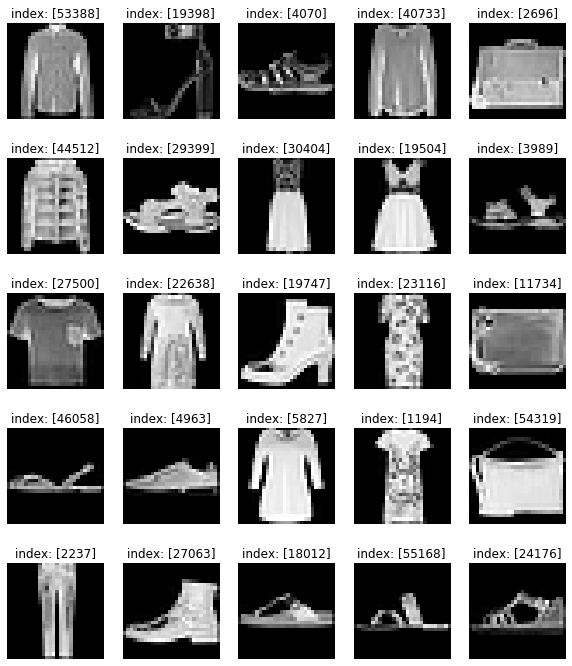

In [7]:
plt.figure(figsize=(10, 12))

for i in range(25):
    # [[YOUR CODE]]
    img=np.random.choice(60000,1, replace=False)
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[img].reshape(28, 28), cmap='gray')
    plt.title(f'index: {img}')
    plt.axis('off')

plt.show()

### 데이터를 tensorflow 데이터셋의 형태로 만들어주기

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# batch: 데이터를 BATCH_SIZE(=256)만큼 나눈다
print(train_dataset.element_spec)

TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)


### Tensorflow 2.0 Tutorial의 DCGAN 구현하기

#### 제너레이터 모델 설계

In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

제너레이터 모델의 summary 

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

노이즈 벡터를 generator에 돌려보자.

In [12]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)  # 학습하고 있지 않으니까
generated_image.shape

TensorShape([1, 28, 28, 1])

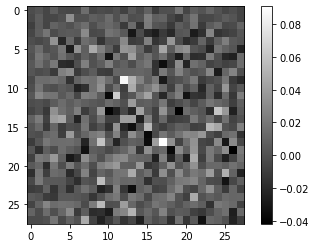

In [13]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

### Discriminator 모델 만들기

In [14]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00016999]], dtype=float32)>

 This is the model's prediction, i.e, a single floating-point value which either represents a logit, (i.e, value in [-inf, inf] when from_logits=True) or a probability (i.e, value in [0., 1.] when from_logits=False).

In [17]:
# 손실함수

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

앞으로 쓰여질 fake_output과 real_output은   
- fake_output: 생성자가 생성한 fake image를 구분자에 입력시켜서 판별된 값, D(fake_image)
- real_output: 기존에 있던 real image를 구분자에 입력시켜서 판별된 값, D(real_image)


### generator_loss
- gnerator_loss는 fake_output이 1에 가까워지기를 바라므로, tf.ones_like를 사용해서 fake_output과 같은 shape의 tensor에 1을 채운 값과 fake_output 사이의 cross entropy를 계산한다. 
- 만일 fake_output이 1에 가까우면 generator_loss는 매우 작은 값에 가까워지게 된다.


In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss
- discriminator_loss는 실제 이미지인지, 만들어낸 이미지인지를 구분해내야 하므로 real_output 값은 1, fake_output값은 0에 가까워지기를 원한다. 그러므로 real_output과 fake_output의 loss를 모두 구한다. 
- 최종적인 discriminator_loss는 fake_loss와 real_loss를 더한 값이다.

In [19]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

discriminator_accuracy의 accuracy 코드를 단계별로 나눠보면

In [29]:
# 임의로 만든 output
real_output=tf.constant([0.5,0.1, 0.9, 0.6,0.4]) 
fake_output=tf.constant([0.1,0.3, 0.8, 0.6,0.7])

# 0.5 이상은 True, 0.5미만은 False
print("tf.math.greater_equal을 사용해서 0.5이상은 True")
print(tf.math.greater_equal(real_output, tf.constant([0.5])))
print("--------------------------------------")

# True는 1, False는 0
print("tf.cast를 사용해서 True 1, False 0")
print(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
print("---------------------------------------")

# reduce_mean은 차원을 감소하면서 평균을 구한다는 의미이다.
# 1차원 벡터의 element의 평균을 구하면 스칼라(숫자 하나)가 되니까 차원을 감소한다는 뜻
print("tf.reduce_mean을 사용해서 평균 구함")
print(tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32)))

tf.math.greater_equal을 사용해서 0.5이상은 True
tf.Tensor([ True False  True  True False], shape=(5,), dtype=bool)
--------------------------------------
tf.cast를 사용해서 True 1, False 0
tf.Tensor([1. 0. 1. 1. 0.], shape=(5,), dtype=float32)
---------------------------------------
tf.reduce_mean을 사용해서 평균 구함
tf.Tensor(0.6, shape=(), dtype=float32)


In [31]:
# real output의 accuracy와 face output의 accuracy
real_acc, fake_acc=discriminator_accuracy(real_output, fake_output)
print(real_acc.numpy(), fake_acc.numpy(), sep="\n") 

0.6
0.4


###  gnerator와 discriminator의 optimizer를 구분해서 만든다.

In [32]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [47]:
tf.random.set_seed(2) # tensorflow의 seed 고정
noise_dim = 100 # 노이즈의 차원
num_examples_to_generate = 16 # 샘플 16장 만들 것이다.


seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape
print(seed.numpy()[1]) # 고정된 값이 나온다.

[-5.7826084e-01 -1.1437217e+00 -9.2064869e-01  1.7580733e+00
 -1.2162539e+00 -1.9602589e-01  4.4740897e-01 -2.2539118e-01
 -1.7802756e+00  2.5665593e-01  2.3188332e-01  5.4489434e-01
 -5.0694585e-01 -1.4859351e+00  5.1586372e-01 -9.3534285e-01
 -3.0865273e-01  1.0117605e+00  2.1073802e+00 -1.7513493e-02
  3.3134562e-01  2.1589470e+00 -4.0530252e-01 -7.4151200e-01
  3.7811527e-01  3.4771526e-01 -1.4415126e+00 -1.7167249e+00
  1.3056867e+00  3.6701348e-01 -2.0287786e-01  3.5078636e-01
 -2.0768536e-02 -1.4060150e-01  1.5034269e+00 -8.0088759e-03
 -6.6500074e-01 -1.6700591e-01  1.1341398e+00 -1.1808697e+00
  7.0336121e-01 -3.8515747e-01 -8.4263909e-01  2.2536202e-01
 -1.5897037e-01  1.1140791e+00  4.2790797e-01 -1.6697542e-01
 -1.6763417e+00  1.2362867e-02 -4.3588972e-01 -2.7143629e-02
  3.5220426e-01  1.0627210e+00 -3.6884606e-02  3.9599860e-01
  2.7246266e-03 -2.6746755e+00  1.2242303e+00  1.4673905e+00
 -1.4454123e+00 -9.9293536e-01 -4.9208182e-01 -1.3954933e+00
  8.6111790e-01  8.02286

### 훈련과정 설계하기
- 데코레이션을 사용해서 graph computation을 설계한다. (Appendix A. 데코레이션을 참고)
- tf.GradientTape는 컨텍스트 안에서 실행된 모든 연산을 테이프(tape)에 기록한다. generator의 gradient는 gen_tape, discriminator의 gradient는 disc_tape에 기록된다.

In [48]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8)-1. generator의 gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    #(8)-2. discriminator의 gradient 계산
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 한단계씩 학습할 train_step과 함께 일정간격으로 이미지가 생성되는 모습을 보여주는 함수

In [49]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False) # generator 모델이 만들어낸 이미지

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1) # subplot으로 만든다.
        plt.imshow(predictions[i, :, :, 0], cmap='gray') #
        plt.axis('off')
   # 이미지 저장
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### 모델의 학습과정을 체크하는 그래프
- gen_loss, disc_loss 그래프
- fake_accuracy, real_accuracy의 그래프

In [50]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

모델의 버전관리를 한다. checkpoint에는 생성자와 판별자가 학습한 모델의 가중치를 저장한다.

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 모델학습

In [51]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

### GPU 디바이스 확인 및 모델 저장간격(save_every), 학습 에포크(EPOCHS) 설정

In [52]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[]

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

### 학습과정 시각화

In [53]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

### chechpoint모듈을 활용해서 모델을 로드하는 예시

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [ ]:

#%%time
#train(train_dataset, EPOCHS, save_every)

GAN훈련 과정 개선하기